In [1]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
#from tensorflow.random import set_seed

In [2]:
numpy_seed = 0
np.random.seed(numpy_seed)
tensorflow_seed = 0
#set_seed(tensorflow_seed)

In [3]:
#SAVE_DIRECTORY = "../data/"
MODEL_DIRECTORY = "E:/Id_diff/models"
dim = (224, 224)
#X = np.load(SAVE_DIRECTORY+"X.npy")
#y = np.load(SAVE_DIRECTORY+"y.npy")
X = np.load("E:/Id_diff/X.npy")
#print(X)
#plt.imshow(X)
y = np.load("E:/Id_diff/y.npy")
#print(y)

In [4]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.35)
del(X,y)

In [5]:
#X_train=X_train/255.0
#y_train=y_train/255.0
print(X_train.shape)
print(y_train.shape)

(13, 224, 224, 3)
(13,)


In [6]:
#X_train = X_train.reshape(X_train.shape[0], 224, 224, 1)
#X_test = X_test.reshape(X_test.shape[0], 224, 224, 1)
#print(X_train.shape)

In [7]:
from tensorflow.keras.applications import MobileNet
import tensorflow as tf
 

def build_model_1(dim):
    #base_model=tf.keras.Sequential()
    base_model=MobileNet(weights='imagenet',include_top=False,
                                               input_shape=(dim[0],dim[0],3),pooling="avg")
   
    #base_model.layers.pop()
    #base_model=base_model.layers[-1].output
    
    reduce_base_model =Sequential()
   
    
    for layer in base_model.layers[:10]: # just exclude last layer from copying
        reduce_base_model.add(layer)
    #for layer in base_model.layers:
        #layer.trainable = False
    #base_model.add(GlobalAveragePooling2D())
    
    #base_model.add(Dense(128, activation='elu'))
    #base_model.add(Dense(1, activation='sigmoid'))
    #base_model=keras.Sequential()
    #base_model.add()
    
    return reduce_base_model
    #return base_model

base_model=build_model_1(dim)
base_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0

In [8]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D,Activation 
from tensorflow.keras.layers import Flatten,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.regularizers import l2
Regularizer = l2(0.001)

def build_model(dim):
    
    base_model = Sequential()
    base_model.add(Conv2D(32, kernel_size=(3,3),input_shape=(dim[0],dim[0],3)))
    base_model.add(BatchNormalization())
    base_model.add(Activation('elu'))
    base_model.add(MaxPool2D(pool_size=(2, 2)))
    
    #base_model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same',activity_regularizer=Regularizer,kernel_regularizer=Regularizer))
    #base_model.add(BatchNormalization())
    #base_model.add(Activation('elu'))
    #base_model.add(MaxPool2D(pool_size=(2, 2)))
    
    
    base_model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same' ))
    base_model.add(BatchNormalization())
    base_model.add(Activation('elu'))
    base_model.add(MaxPool2D(pool_size=(2, 2)))
    
    base_model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same'))
    base_model.add(BatchNormalization())
    base_model.add(Activation('elu')) 
    base_model.add(MaxPool2D(pool_size=(2, 2)))
    
    base_model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')) 
                           
    base_model.add(BatchNormalization())
    base_model.add(Activation('elu')) 
    base_model.add(MaxPool2D(pool_size=(2, 2)))
     
    # hidden layer
    base_model.add(GlobalAveragePooling2D())
    #base_model.add(Flatten())
    base_model.add(Dense(128,activation='elu'))
    base_model.add(Dropout(0.25))
    base_model.add(Dense(1, activation='sigmoid'))
    return base_model


#base_model = MobileNet(input_shape=(dim[0],dim[0],3), include_top=False,
                       #weights='imagenet', pooling="avg")
#base_model=build_model(dim)
#base_model.summary()

In [9]:
#model = Sequential()
#model.add()
from tensorflow.keras import Input
base_model = Sequential([
                        Input(shape=(dim[0],dim[0],3)),
                        base_model,
                        GlobalAveragePooling2D(),
                        Dense(128, activation="elu"),
                        Dense(1, activation="sigmoid")
                        ])
for layer in base_model.layers:
    layer.trainable = True
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 112, 112, 64)      3712      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 12,161
Trainable params: 11,905
Non-trainable params: 256
_________________________________________________________________


In [10]:
BATCH_SIZE = train_size = len(X_train)
learning_rate = (1e-4)*1
optimizer = Nadam(learning_rate= learning_rate)
base_model.compile(optimizer =optimizer, loss = ["binary_crossentropy"], 
              metrics = ["accuracy",Precision(), Recall()])
epochs=300

In [11]:
import math
from keras.callbacks import LearningRateScheduler

# learning rate schedule
def step_decay(epoch):
    initial_lrate = (1e-2)*1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)
callbacks = [lrate]

Using TensorFlow backend.


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
         rotation_range=20,
         zoom_range=0.15,
         width_shift_range=0.2,
         height_shift_range=0.2,
         shear_range=0.15,
         horizontal_flip=True,
         fill_mode="nearest"
         )

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_path = "E:/Id_diff/model/base_model.h5"
#checkpoint_path = "E:/Id_diff/model/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_cb = [ModelCheckpoint(
                                filepath=model_path, 
                                monitor = 'val_loss', 
                                save_best_only=True,
                                verbose=1,
                                mode = "min")]
history = base_model.fit(
                    X_train, y_train,
                    batch_size=BATCH_SIZE,
                    #x=aug.flow(X_train, y_train,batch_size=BATCH_SIZE),
                    epochs = epochs, 
                    validation_data =(X_test, y_test),
                    #validation_data=aug.flow(X_test, y_test),   
                    callbacks=checkpoint_cb,
                    #shuffle = True
                        )

Train on 13 samples, validate on 7 samples
Epoch 1/300

Epoch 00001: val_loss improved from inf to 0.68352, saving model to E:/Id_diff/model/base_model.h5
13/13 [==============================] - 2s 177ms/sample - loss: 0.7087 - accuracy: 0.5385 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6835 - val_accuracy: 0.4286 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300

Epoch 00002: val_loss improved from 0.68352 to 0.67562, saving model to E:/Id_diff/model/base_model.h5
13/13 [==============================] - 1s 40ms/sample - loss: 0.6900 - accuracy: 0.6154 - precision: 1.0000 - recall: 0.1667 - val_loss: 0.6756 - val_accuracy: 0.4286 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/300

Epoch 00003: val_loss improved from 0.67562 to 0.66937, saving model to E:/Id_diff/model/base_model.h5
13/13 [==============================] - 1s 40ms/sample - loss: 0.6783 - accuracy: 0.6154 - precision: 1.0000 - recall: 0.1667 - val_loss: 0.6694 - val_accuracy

In [14]:
history_dict = history.history
keys = history_dict.keys()
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
precision = history_dict['precision']
val_precision = history_dict['val_precision']
recall = history_dict['precision']
val_recall = history_dict['val_recall']

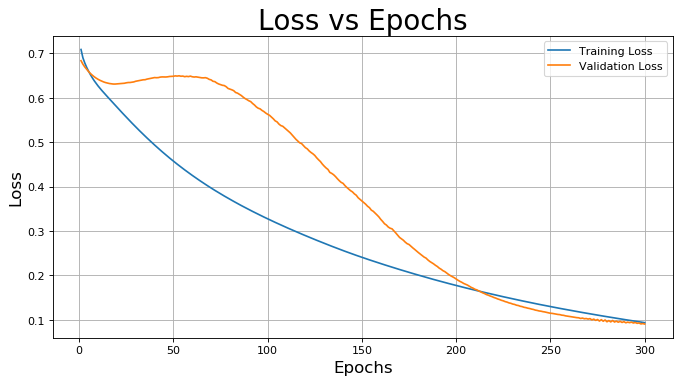

In [15]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss,  label='Training Loss')
plt.plot(epochs, val_loss,  label='Validation Loss')
plt.title('Loss vs Epochs', fontsize = 25)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend()
plt.grid(True)
plt.show()

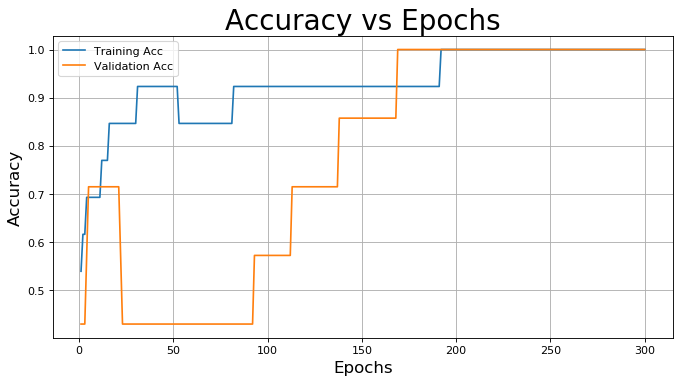

In [16]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc,  label='Training Acc')
plt.plot(epochs, val_acc,  label='Validation Acc')
plt.title('Accuracy vs Epochs', fontsize = 25)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.grid(True)
plt.show()